In [1]:
# %pip install urllib

In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from unet import UNet
import urllib

In [3]:
device = "mps"

In [4]:
filename = 'dog.jpeg'
image = Image.open(filename)

In [5]:
# def get_sample_image()-> Image.Image:
#     url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
#     filename = 'racoon.jpg'
#     urllib.request.urlretrieve(url, filename)
#     return Image.open(filename)

In [6]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

In [22]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().detach().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().detach().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [8]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps=300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x0, t, device):
        noise = torch.rand_like(x0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x0.shape)
        #alpha_hat_t = alpha_hat.gather(-1,t).reshape(-1,1,1,1)
        
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1-self.alphas_cumprod), t, x0.shape)
        #variance = [[torch.sqrt(1 - alpha_hat_t)]] <- this part * noise
        
        mean = sqrt_alphas_cumprod_t.to(device) + x0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)

       
    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        
        result = values.gather(-1, t.cpu())
        # alpha_hat_t = [[alpha_hat.gather(-1,t)]] <-- this one .reshape(-1,1,1,1)
        
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device) #reshape(-1,1,1,1) <- this is the one

In [9]:
IMAGE_SHAPE = (32,32)

In [10]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1),
])

In [11]:
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t+1)/2),
    transforms.Lambda(lambda t: t.permute(1,2,0)),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.cpu().detach().numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])

In [12]:
# image = get_sample_image()
torch_image = transform(image)

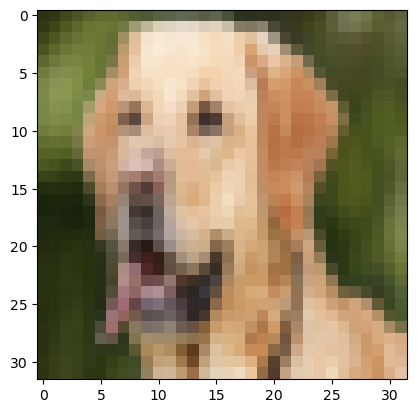

In [13]:
plt.imshow(reverse_transform(torch_image))

In [14]:
diffusion = DiffusionModel()

In [15]:
NO_OF_IMAGE = 5

<Figure size 1500x1500 with 0 Axes>

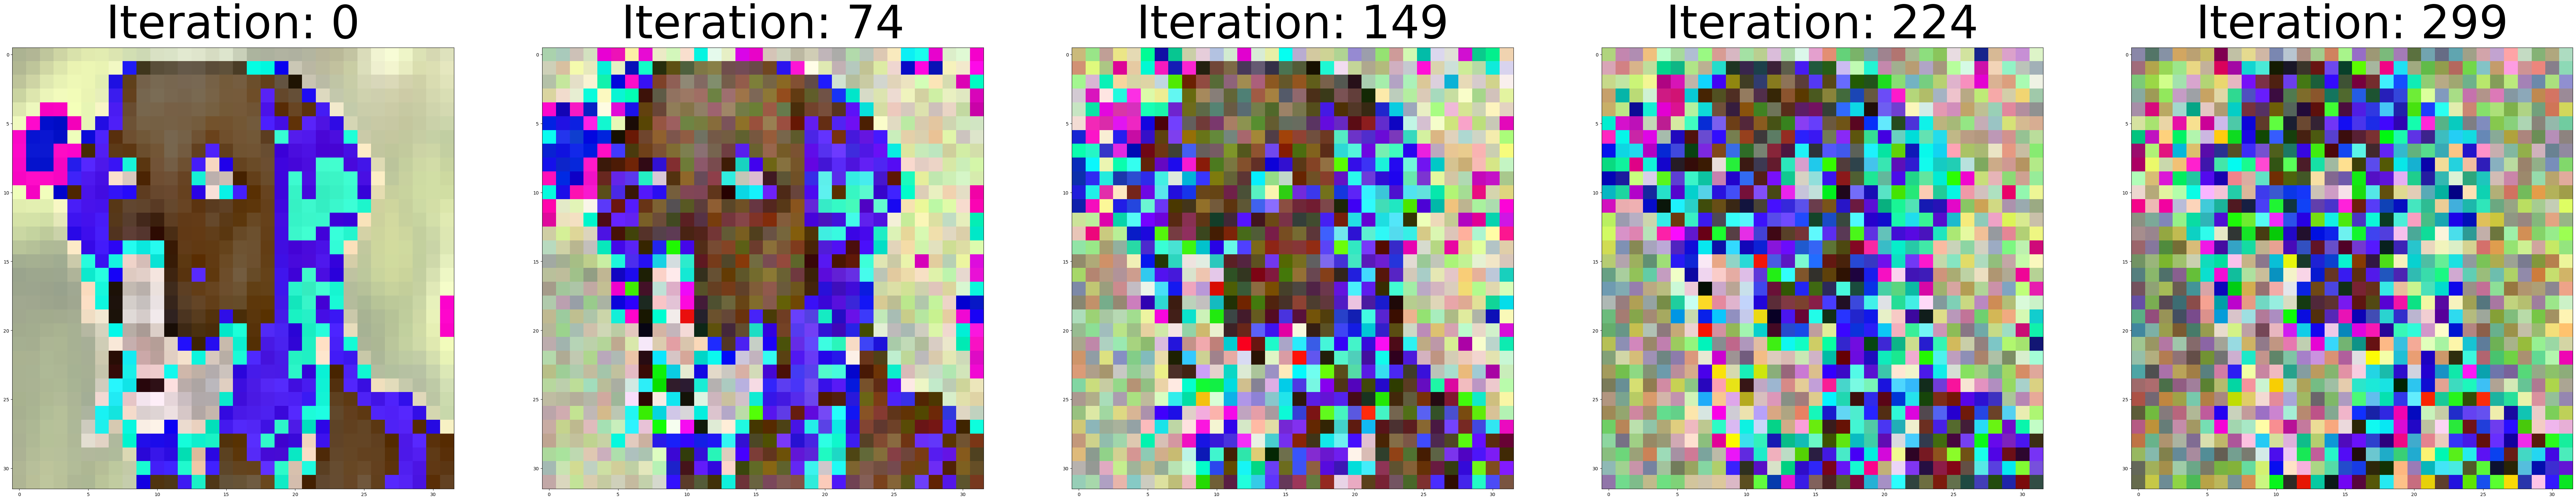

In [16]:
torch_image_batch = torch.stack([torch_image] * NO_OF_IMAGE)
t = torch.linspace(0, diffusion.timesteps - 1, NO_OF_IMAGE).long()
noisy_image_batch, _ = diffusion.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_OF_IMAGE, figsize=(100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize=100)
plt.show()

In [17]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [18]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()
        
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)
        
        self.downsample = downsample
        
        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
            
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]
            
        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

In [19]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [20]:
# unet = UNet().to(device)
# NO_EPOCHS = 2000
# PRINT_FREQUENCY = 400
# LR = 0.001
# BATCH_SIZE = 128
# optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet()
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

---


<Figure size 1500x1500 with 0 Axes>

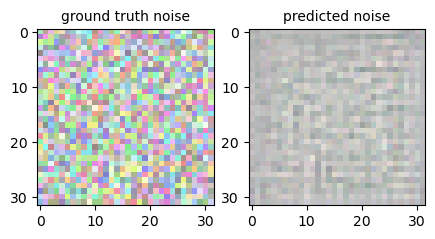

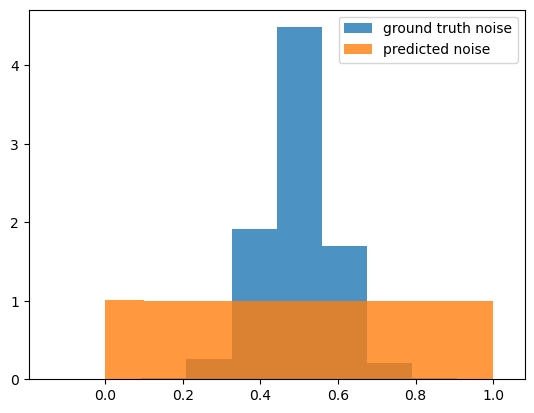

---


<Figure size 1500x1500 with 0 Axes>

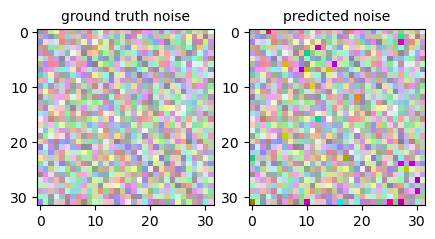

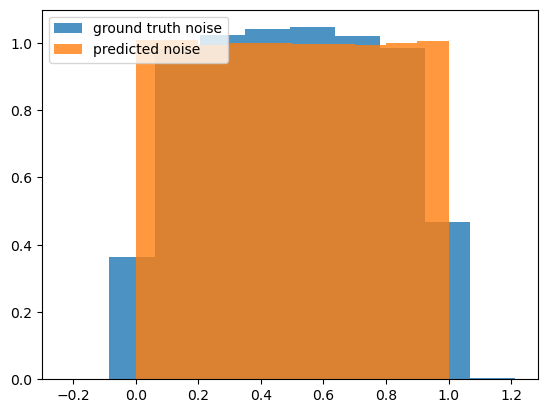

---


<Figure size 1500x1500 with 0 Axes>

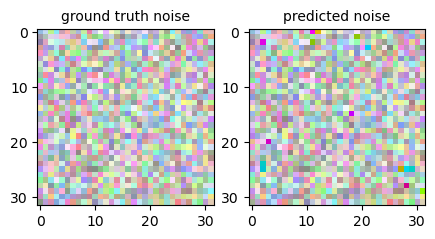

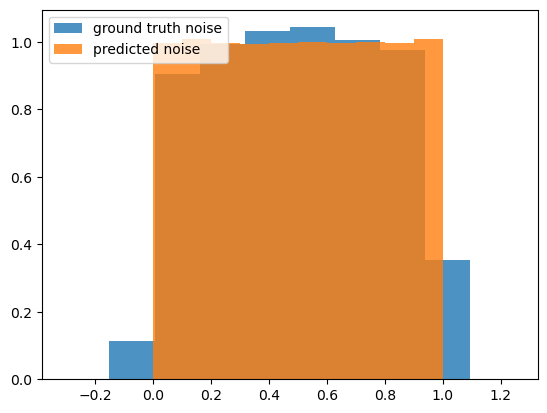

---


<Figure size 1500x1500 with 0 Axes>

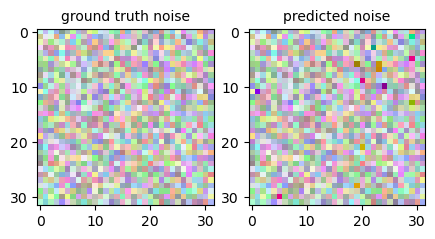

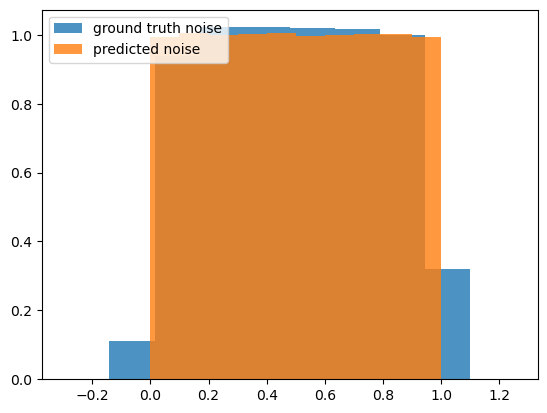

---


<Figure size 1500x1500 with 0 Axes>

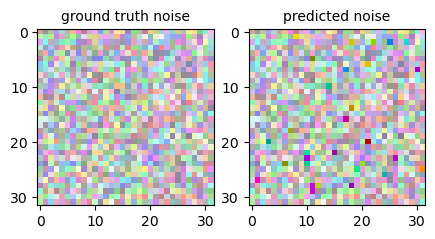

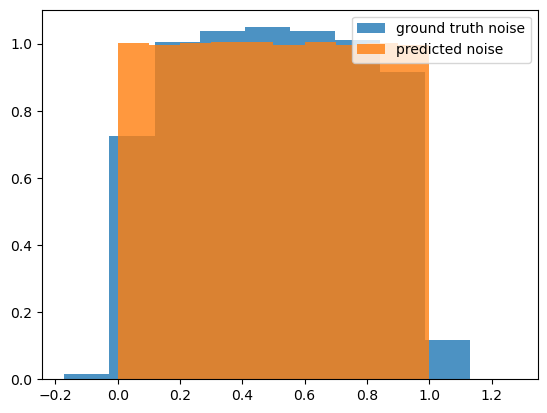

In [24]:
for epochs in range(NO_EPOCHS):
    mse_loss_epochs = []
    
    batch_size = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion.timesteps, (BATCH_SIZE,)).long().to(device)
    noisy_image, gt_noise = diffusion.forward(batch_size, t, device)
#     print(noisy_image.size())
    predicted_noise = unet(noisy_image, t)
    
    # rudimentary optimization code
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(gt_noise, predicted_noise)
    mse_loss_epochs.append(loss)
    loss.backward()
    optimizer.step()

    
    
    if epochs % PRINT_FREQUENCY == 0:
        print("---")
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        plot_noise_prediction(gt_noise[0], predicted_noise[0])
        plot_noise_distribution(predicted_noise, gt_noise)